# README

The ultimate aim of this notebook is to construct a **naive** *implied order book* for SPX options (options on the S&P500). We will explain what this means in more detail. The data comes from the Chicago Board Options Exchange (CBOE). The data is delayed (hence why it's free!). Here's the link to the page where the data comes from. https://www.cboe.com/delayed_quotes/spx/quote_table

When we make a call to the API we get back a table containing all option contracts on the S&P500 (one row per contract), with some info about the contract:
* The ID tells us the expiry, whether it's a put or a call and the strike price.
* The current bid and ask prices, as well as the bid and ask sizes
* Implied Vol (need to work out whether this is from bid, ask, mid or something else - may need to write my own Black-Scholes function for this)
* Open Interest (total number of open contracts)
* Volume
* The Greeks - delta, gamma, vega, theta, rho, theo
* Some metrics about how the price has changed
* Last traded time and last traded price. This can help to show liquidity.

What this dataset doesn't tell you... EXPLAIN WHY IT'S NAIVE

# Imports

In [1]:
import requests
import json
import pandas as pd
from datetime import datetime

# Fetch Data

In [2]:
# Symbol for SPX options
symbol = '_SPX'

# Start session
s = requests.Session()

# Make API call and check status code
response = s.get(f'https://cdn.cboe.com/api/global/delayed_quotes/options/{symbol}.json')
if response.status_code != 200:
    raise Exception(f"Unable to fetch data. Status code is {response.status_code}")

# Get data as json
data = json.loads(response.content)

# Close session
s.close()

In [3]:
data

{'timestamp': '2024-11-07 16:58:29',
 'data': {'options': [{'option': 'SPX241115C00200000',
    'bid': 5758.9,
    'bid_size': 24.0,
    'ask': 5768.4,
    'ask_size': 24.0,
    'iv': 7.4825,
    'open_interest': 16.0,
    'volume': 0.0,
    'delta': 1.0,
    'gamma': 0.0,
    'vega': 0.0003,
    'theta': 0.0,
    'rho': 0.0555,
    'theo': 5763.3823,
    'change': 0.0,
    'open': 0.0,
    'high': 0.0,
    'low': 0.0,
    'tick': 'down',
    'last_trade_price': 5655.41,
    'last_trade_time': '2024-10-18T12:12:30',
    'percent_change': 0.0,
    'prev_day_close': 5729.69995117188},
   {'option': 'SPX241115P00200000',
    'bid': 0.0,
    'bid_size': 0.0,
    'ask': 0.05,
    'ask_size': 199.0,
    'iv': 6.3143,
    'open_interest': 116.0,
    'volume': 0.0,
    'delta': 0.0,
    'gamma': 0.0,
    'vega': 0.0003,
    'theta': -0.0067,
    'rho': 0.0,
    'theo': 0.0091,
    'change': 0.0,
    'open': 0.0,
    'high': 0.0,
    'low': 0.0,
    'tick': 'no_change',
    'last_trade_price': 

In [4]:
# Get timestamp
timestamp = datetime.strptime(data['timestamp'], "%Y-%m-%d %H:%M:%S")

# Get index price
index_price = data['data']['current_price']

# Get options data
df = pd.DataFrame(
    data=data['data']['options']
)

df['Index Price'] = index_price
df['timestamp'] = timestamp

# Extract info from the ID column
without_w = df['option'].str.replace("W", "")
df['Expiry'] = without_w.str[3:9]
df['Type'] = without_w.str[9]
df['Strike'] = without_w.str[11:-3].astype(int)

# Calculate moneyness
df['Moneyness'] = (df['Index Price'] - df['Strike']) / df['Strike']


In [5]:
df

,option,bid,bid_size,ask,ask_size,iv,open_interest,volume,delta,gamma,...,last_trade_price,last_trade_time,percent_change,prev_day_close,Index Price,timestamp,Expiry,Type,Strike,Moneyness
0,SPX241115C00200000,5758.9,24.0,5768.40,24.0,7.4825,16.0,0.0,1.0000,0.0000,...,5655.41,2024-10-18T12:12:30,0.0000,5729.699951,5965.9102,2024-11-07 16:58:29,241115,C,200,28.829551
1,SPX241115P00200000,0.0,0.0,0.05,199.0,6.3143,116.0,0.0,0.0000,0.0000,...,0.00,None,0.0000,0.025000,5965.9102,2024-11-07 16:58:29,241115,P,200,28.829551
2,SPX241115C00400000,5559.2,24.0,5568.70,24.0,5.9090,1.0,0.0,1.0000,0.0000,...,5428.84,2024-10-21T11:17:52,0.0000,5530.000000,5965.9102,2024-11-07 16:58:29,241115,C,400,13.914776
3,SPX241115P00400000,0.0,0.0,0.05,160.0,4.9792,972.0,0.0,0.0000,0.0000,...,0.05,2024-10-31T15:47:22,0.0000,0.025000,5965.9102,2024-11-07 16:58:29,241115,P,400,13.914776
4,SPX241115C00600000,5359.5,24.0,5368.90,24.0,4.9557,0.0,0.0,1.0000,0.0000,...,0.00,None,0.0000,5330.350098,5965.9102,2024-11-07 16:58:29,241115,C,600,8.943184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25601,SPXW250930P07400000,1176.0,1.0,1209.00,1.0,0.1157,0.0,0.0,-0.9486,0.0002,...,0.00,None,0.0000,1222.000000,5965.9102,2024-11-07 16:58:29,250930,P,7400,-0.193796
25602,SPXW250930C07600000,8.8,55.0,9.10,14.0,0.1182,71.0,0.0,0.0365,0.0001,...,8.00,2024-11-06T15:45:09,0.0000,7.950000,5965.9102,2024-11-07 16:58:29,250930,C,7600,-0.215012
25603,SPXW250930P07600000,1362.5,1.0,1395.40,1.0,0.1179,1.0,0.0,-0.9687,0.0001,...,1522.36,2024-10-11T10:17:15,0.0000,1408.850037,5965.9102,2024-11-07 16:58:29,250930,P,7600,-0.215012
25604,SPXW250930C07800000,5.7,61.0,6.10,163.0,0.1217,101.0,1.0,0.0244,0.0001,...,6.00,2024-11-07T11:32:54,14.2857,5.250000,5965.9102,2024-11-07 16:58:29,250930,C,7800,-0.235140


# Data Exploration

In [6]:
test_df = df[(df['Expiry'] == '241220') & (df['Type'] == 'P')]

In [7]:
test_df = test_df[['Strike', 'delta', 'gamma', 'iv']]
test_df.set_index('Strike', inplace=True)

<Axes: xlabel='Strike'>

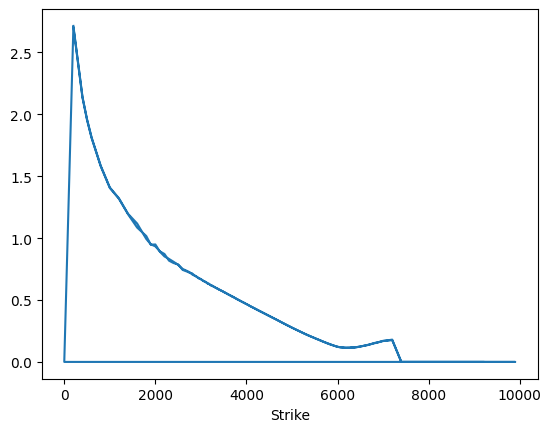

In [8]:
test_df['iv'].plot()

In [9]:
# Vol smirk